In [1]:
%load_ext autoreload
%autoreload 2
%aimport


Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import numpy as np 
import pickle
import pandas as pd
from tqdm import tqdm

import multicam

import matplotlib.pyplot as plt

from multicam.plotting import set_rc


In [3]:

metadata_file = "../../data/processed/tng/tng300-1-table.csv"
tng_snapshot_dir = "../../data/processed/tng/TNG300-1/"  # everything is a host halo
tng_dark_snapshot_dir = "../../data/processed/tng/TNG300-1-Dark/"

trees_file = "../../data/processed/tng/TNG300-1_cut_trees.p"
present_snapfile = tng_snapshot_dir + "TNG300-1_HaloHistory_MBP_snap99.hdf5"

dark_trees_file = "../../data/processed/tng/TNG300-1-Dark_cut_trees.p"
present_dark_snapfile = tng_dark_snapshot_dir + "TNG300-1-Dark_HaloHistory_MBP_snap99.hdf5"

color_file = "../../data/processed/tng/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5"


In [4]:
from multicam.correlations import spearmanr
from multicam.plotting import LATEX_PARAMS_TNG


## Useful Functions

In [5]:
# def plot_corrs_w_scales(axes:list, cat_peak_combs:list, scales:np.ndarray, params:List[str],
#                             titles:List[str], legend_size=14, title_size='medium', labels_indx=(0,)):
#     """Draw correlation as a function of scale into `axes`."""


## Run pipeline to extract DMO and Hydro catalogs

In [6]:
from multicam.tng.utils import hydro_dm_match_pipeline

data = hydro_dm_match_pipeline(present_snapfile, present_dark_snapfile, trees_file, dark_trees_file, metadata_file, color_file, mass_bin=(12.8, 13.1), mbin_fudge = 0.2)


/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)
/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)
100%|██████████| 3293/3293 [00:40<00:00, 81.19it/s] 
/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:330: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cat["vmax/vvir"] = get_vmax_over_vvir(cat)


In [7]:
cat, dcat = data['cat'], data['dcat']
m_peak, dm_peak = data['m_peak'], data['dm_peak']
scales = data['scales']

len(cat), len(dcat)

(2931, 2931)

In [8]:
# avoid correlations and other issues with very last bin which is always 1
m_peak = m_peak[:, :-1]
dm_peak = dm_peak[:, :-1]
scales = scales[:-1]

m_peak.shape, dm_peak.shape, scales.shape


((2931, 79), (2931, 79), (79,))

In [10]:
# add fgas to the catalog
cat['f_gas'] = cat['Mgas_vir'] / ( cat['Mvir'] + cat['Mgas_vir'] + cat['Mstar_vir'] )

(array([ 14.,  32.,  85., 215., 493., 734., 803., 410., 124.,  21.]),
 array([0.31431318, 0.31631392, 0.31831466, 0.32031539, 0.32231613,
        0.32431686, 0.3263176 , 0.32831834, 0.33031907, 0.33231981,
        0.33432054]),
 <BarContainer object of 10 artists>)

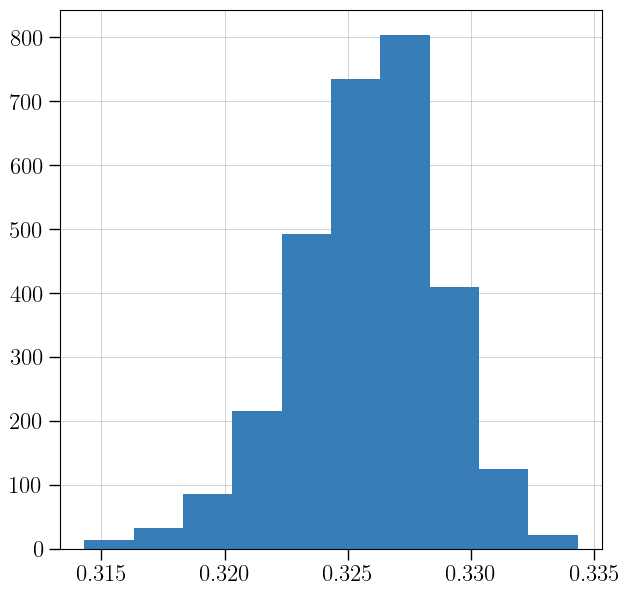

In [23]:
plt.hist(cat['f_gas'])

## Correlations with DMO properties

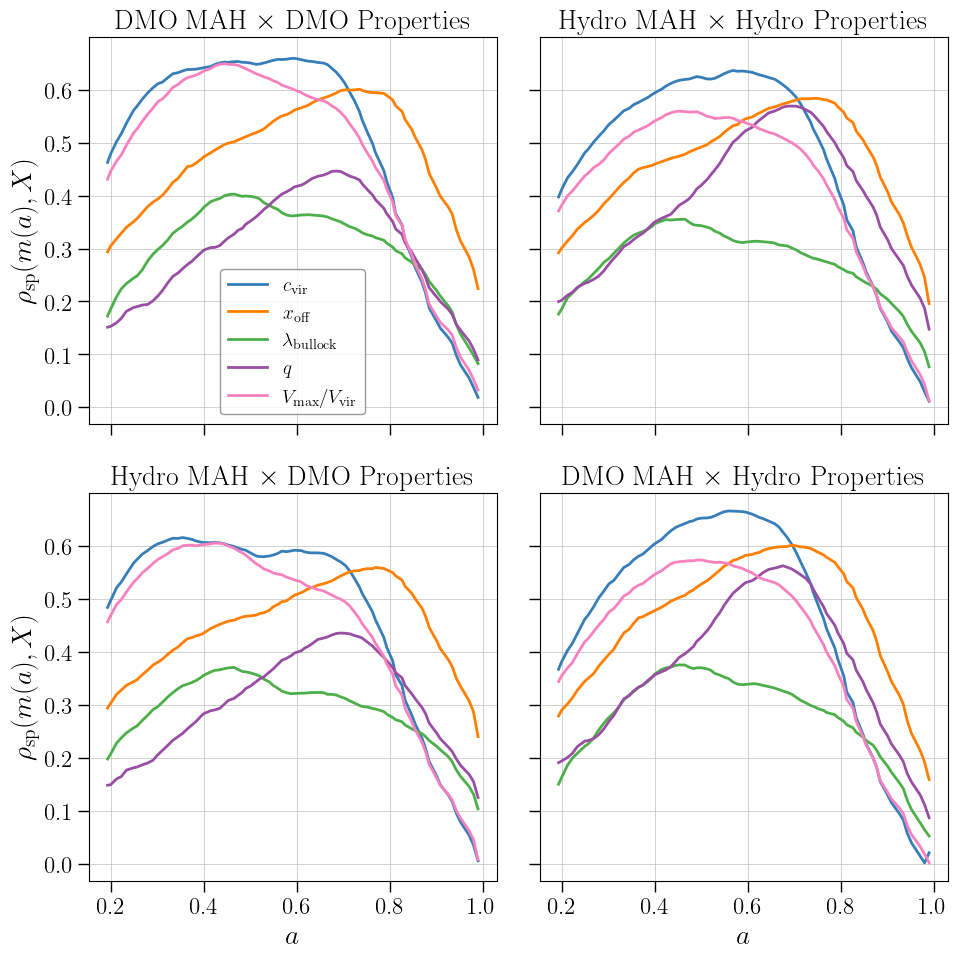

In [9]:
set_rc()

dmo_params = ['cvir', 'X_off_DM', 'Spin_Bullock_DM', 'q_DM', 'vmax/vvir']

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

cat_peak_combs = [
                (dcat, dm_peak), 
                (cat, m_peak), 
                (dcat, m_peak),
                (cat, dm_peak),
            ]
titles = [
          r'\rm DMO MAH $\times$ DMO Properties', 
          r'\rm Hydro MAH $\times$ Hydro Properties', 
          r'\rm Hydro MAH $\times$ DMO Properties', 
          r'\rm DMO MAH $\times$ Hydro Properties'
        ]

for ii, (ax, title, (_cat, _peak)) in enumerate(zip(axes, titles, cat_peak_combs)):
    for param in dmo_params:
        corrs = [] 
        for jj in range(_peak.shape[1]):
            corrs.append(abs(spearmanr(_cat[param], _peak[:, jj])))
        ax.plot(scales, corrs, label=LATEX_PARAMS_TNG[param])

    if ii in [0, 2]:
        ax.set_ylabel(r'$\rho_{\rm sp}(m(a), X)$')
    
    if ii in [2, 3]:
        ax.set_xlabel(r'$a$')
    ax.set_title(title, fontsize='medium')

    if ii == 0:
        ax.legend(prop={'size': 14})


plt.tight_layout()

fig.savefig("../../results/tng/mah_dm_correlations.png", bbox_inches='tight')


## Correlations with Hydro properties

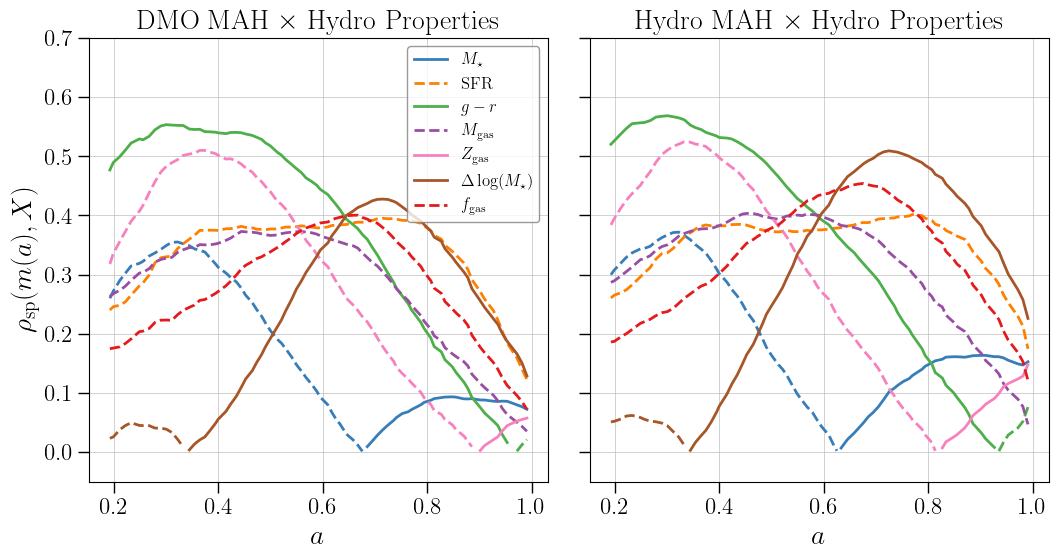

In [15]:
from multicam.correlations import spearmanr
from multicam.plotting import LATEX_PARAMS_TNG

set_rc()

# TODO: add Mvir?
hydro_params = [
    'Mstar_vir', 
    'SFR_vir', 
    'g-r',
    'Mgas_vir', 
    'Zgas_vir',
    'msmhmr', 
    'f_gas',
    # 'Zstar_vir',
]

colors =['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 
         'C6'
         ]


fig, axes = plt.subplots(1, 2, figsize=(11, 6), sharey=True)
axes = axes.flatten()

cat_peak_combs = [(cat, dm_peak), (cat, m_peak)]
titles = [r'\rm DMO MAH $\times$ Hydro Properties', r'\rm Hydro MAH $\times$ Hydro Properties']

for ii, (ax, title, (_cat, _peak)) in enumerate(zip(axes, titles, cat_peak_combs)):
    for color, param in zip(colors, hydro_params):
        corrs = []
        for jj in range(_peak.shape[1]):
            corrs.append(spearmanr(_cat[param], _peak[:, jj]))

        corrs = np.array(corrs)
        scales_neg = scales[corrs < 0]
        scales_pos = scales[corrs > 0]
        corrs_neg = abs(corrs[corrs < 0])
        corrs_pos = abs(corrs[corrs > 0])
        label = LATEX_PARAMS_TNG[param]
        if len(scales_pos) > 0:
            ax.plot(scales_pos, corrs_pos, label=label, ls='-', color=color)
            label = None
        if len(scales_neg) > 0:
            ax.plot(scales_neg, corrs_neg, label=label, ls='--', color=color)


    if ii == 0:
        ax.legend(prop={'size': 12})
        ax.set_ylabel(r'$\rho_{\rm sp}(m(a), X)$')
    
    ax.set_xlabel(r'$a$')
    ax.set_title(title, fontsize='medium')
    ax.set_ylim(-0.05, 0.7)


plt.tight_layout()


fig.savefig("../../results/tng/mah_hydro_correlations.png", bbox_inches='tight')


## MultiCAM prediction and correlations of Hydro and DMO params

In [16]:
from multicam.models import MultiCAM 


n_features = m_peak.shape[1]
n_targets = len(dmo_params) + len(hydro_params)
all_params = dmo_params + hydro_params


model_hydro = MultiCAM(n_features, n_targets)
model_dmo = MultiCAM(n_features, n_targets)

model_hydro.fit(m_peak, cat[all_params].values)
model_dmo.fit(dm_peak, cat[all_params].values)


In [17]:
# now use all dmo properties (from dmo catalog) to predict hydro

n_features = dm_peak.shape[1] + len(dmo_params)
n_targets = len(hydro_params)
x = np.concatenate([dm_peak, dcat[dmo_params].values], axis=1)
y = cat[hydro_params].values
model_dmo_all = MultiCAM(n_features, n_targets)

model_dmo_all.fit(x, y)


In [18]:
# # now use all dmo properties (from dmo catalog) to predict hydro
# exclude = ['HaloID', 'SubhaloID', 'SubhaloID_LastDesc', 'Central', 'Main','dmo_id', 'EndState', 'hydro_match']
# all_dmo_params = [col for col in dcat.columns if col not in exclude]

# n_features = dm_peak.shape[1] + len(all_dmo_params)
# n_targets = len(hydro_params)
# x = np.concatenate([dm_peak, dcat[all_dmo_params].values], axis=1)
# y = cat[hydro_params].values
# model_dmo_all = MultiCAM(n_features, n_targets)

# model_dmo_all.fit(x, y)


In [19]:
hydro_pred = model_hydro.predict(m_peak)
dmo_pred = model_dmo.predict(dm_peak)
dmo_all_pred = model_dmo_all.predict(x)


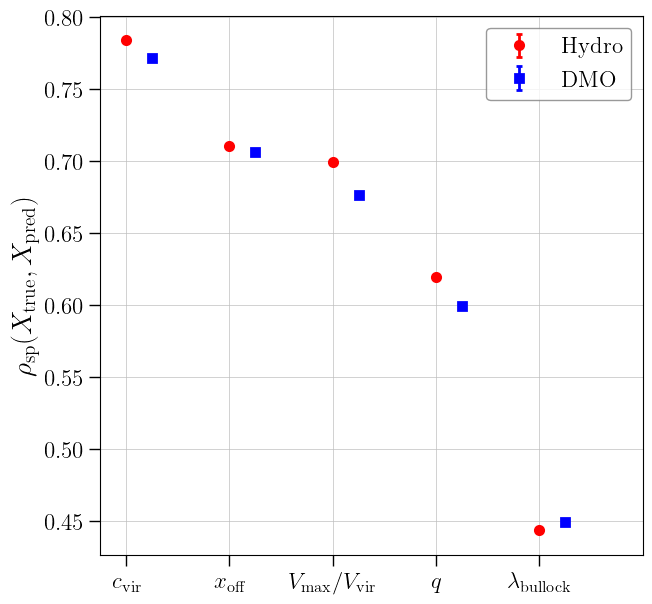

In [20]:
# DMO prediction of hydro sims

# compare spearman correlation plot of predictions from each model 
# x-axis is label with property predicted, y-axis is spearman r of prediction and truth
from multicam.correlations import spearmanr
from multicam.plotting import metrics_plot

set_rc()

# update rc plots fontsize 

n_dmo_params = len(dmo_params)

fig, ax = plt.subplots(1,1, figsize=(7, 7))

# setup latex params in plot
plot_params = [LATEX_PARAMS_TNG[param] for param in dmo_params]

# corrs for hydro and dmo
hydro_corrs = []
dmo_corrs = []
for ii in range(n_dmo_params):
    hydro_corrs.append(spearmanr(cat[all_params].values[:, ii], hydro_pred[:, ii]))
    dmo_corrs.append(spearmanr(cat[all_params].values[:, ii], dmo_pred[:, ii]))

# order by highest correlation to lowest
sort_idx = np.argsort(hydro_corrs)[::-1]
hydro_corrs = np.array(hydro_corrs)[sort_idx]
dmo_corrs = np.array(dmo_corrs)[sort_idx]
plot_params = np.array(plot_params)[sort_idx]

metrics_plot(ax, hydro_corrs, np.zeros((len(hydro_corrs),)), plot_params, r'\rm Hydro', x_bias=0.0)
metrics_plot(ax, dmo_corrs, np.zeros((len(hydro_corrs),)), plot_params, r'\rm DMO', x_bias=0.25, m='s', c='b')

ax.set_ylabel(r'$\rho_{\rm sp}(X_{\rm true}, X_{\rm pred})$', fontsize=20)


plt.legend(loc='best')


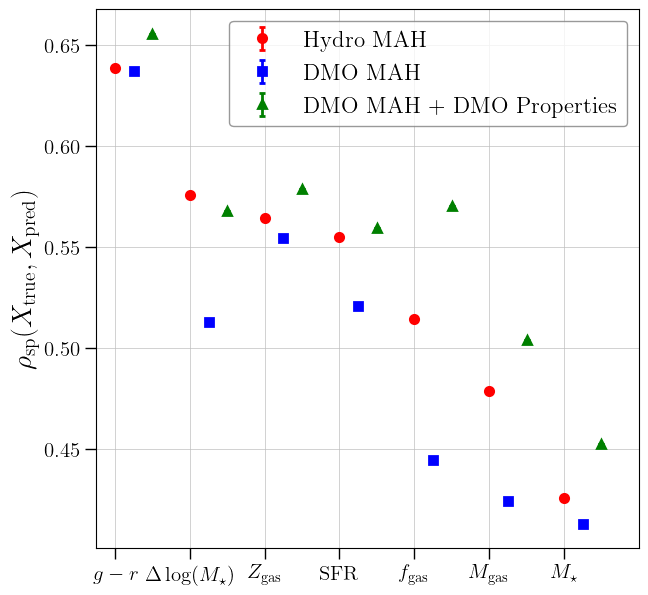

In [21]:
# Hydro prediction 

set_rc()

n_dmo_params = len(dmo_params)
n_hydro_params = len(hydro_params)

fig, ax = plt.subplots(1,1, figsize=(7, 7))

# setup latex params in plot
plot_params = [LATEX_PARAMS_TNG[param] for param in hydro_params]

# corrs for hydro and dmo
hydro_corrs = []
dmo_corrs = []
dmo_all_corrs = []

for ii in range(n_dmo_params, n_hydro_params + n_dmo_params):
    hydro_corrs.append(spearmanr(cat[all_params].values[:, ii], hydro_pred[:, ii]))
    dmo_corrs.append(spearmanr(cat[all_params].values[:, ii], dmo_pred[:, ii]))
    dmo_all_corrs.append(spearmanr(cat[all_params].values[:, ii], dmo_all_pred[:, ii - n_dmo_params]))

# order by highest correlation to lowest
sort_idx = np.argsort(hydro_corrs)[::-1]

hydro_corrs = np.array(hydro_corrs)[sort_idx]
dmo_corrs = np.array(dmo_corrs)[sort_idx]
dmo_all_corrs = np.array(dmo_all_corrs)[sort_idx]
plot_params = np.array(plot_params)[sort_idx]

metrics_plot(ax, hydro_corrs, np.zeros((len(hydro_corrs),)), plot_params, r'\rm Hydro MAH', x_bias=0.0)
metrics_plot(ax, dmo_corrs, np.zeros((len(hydro_corrs),)), plot_params, r'\rm DMO MAH', x_bias=0.25, m='s', c='b')
metrics_plot(ax, dmo_all_corrs, np.zeros((len(hydro_corrs),)), plot_params, r'\rm DMO MAH $+$ DMO Properties', x_bias=0.5, m='^', c='g') 

ax.tick_params(axis='both', labelsize=15)

ax.set_ylabel(r'$\rho_{\rm sp}(X_{\rm true}, X_{\rm pred})$', fontsize=20)

plt.legend(loc='best')

fig.savefig("../../results/tng/hydro_pred_correlations.png", bbox_inches='tight')


## T_Star correlations

In [35]:
[c for c in cat.columns if 'tstar' in c] 


['tstar_vir',
 'tstar_200c',
 'tstar_500c',
 'tstar_2500c',
 'tstar_10pkpc',
 'tstar_30pkpc',
 'tstar_100pkpc']

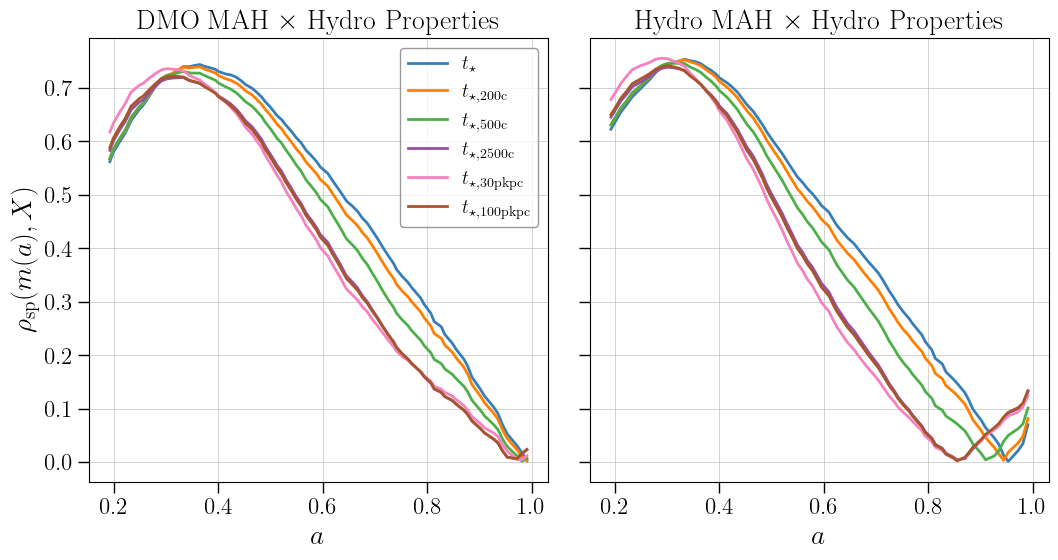

In [36]:
from multicam.plotting import LATEX_PARAMS_TNG
from multicam.correlations import spearmanr

t_params = ['tstar_vir', 'tstar_200c', 'tstar_500c', 'tstar_2500c', 'tstar_30pkpc', 'tstar_100pkpc']

fig, axes = plt.subplots(1, 2, figsize=(11, 6), sharey=True)
axes = axes.flatten()

cat_peak_combs = [(cat, dm_peak), (cat, m_peak)]
titles = [r'\rm DMO MAH $\times$ Hydro Properties', r'\rm Hydro MAH $\times$ Hydro Properties']

for ii, (ax, title, (_cat, _peak)) in enumerate(zip(axes, titles, cat_peak_combs)):
    for param in t_params:
        corrs = [] 
        for jj in range(_peak.shape[1]):
            corrs.append(abs(spearmanr(_cat[param], _peak[:, jj])))
        ax.plot(scales, corrs, label=LATEX_PARAMS_TNG[param])

    if ii == 0:
        ax.legend(prop={'size': 14})
        ax.set_ylabel(r'$\rho_{\rm sp}(m(a), X)$')
    
    ax.set_xlabel(r'$a$')
    ax.set_title(title, fontsize='medium')


plt.tight_layout()

fig.savefig("../../results/tng/mah_tstar_correlations.png", bbox_inches='tight')


## 2D Correlations of Hydro Features (MultiCAM sampling)

In [37]:
from multicam.models import MultiCamSampling

hydro_params = ['Mstar_vir', 'SFR_vir', 'g-r', 'Mgas_vir', 'Zgas_vir', 'msmhmr', 
                #  'Zstar_vir',
                ]
n_targets = len(hydro_params)

dmodel = MultiCamSampling(79, n_targets)
model = MultiCamSampling(79, n_targets)
naive_model = MultiCamSampling(1, n_targets)

# remove nan's and inf's from data
hydro_cat = cat[hydro_params]
mask1 = np.isnan(hydro_cat.values).any(axis=1)
mask2 = np.isinf(hydro_cat.values).any(axis=1)
mask = mask1 | mask2


_dm_peak = dm_peak[~mask]
_m_peak = m_peak[~mask]

x1 = _dm_peak
x2 = _m_peak
x3 = _m_peak[:, [10]] # one random index for x3
y = hydro_cat[:].values[~mask]

x1.shape, x2.shape, x3.shape, y.shape


((2640, 79), (2640, 79), (2640, 1), (2640, 6))

In [38]:
dmodel.fit(x1, y)
model.fit(x2, y)
naive_model.fit(x3, y)


In [39]:
y1 = dmodel.sample(x1, 1)[:, 0, :]
y2 = model.sample(x2, 1)[:, 0, :]
y3 = naive_model.sample(x3, 1)[:, 0, :]


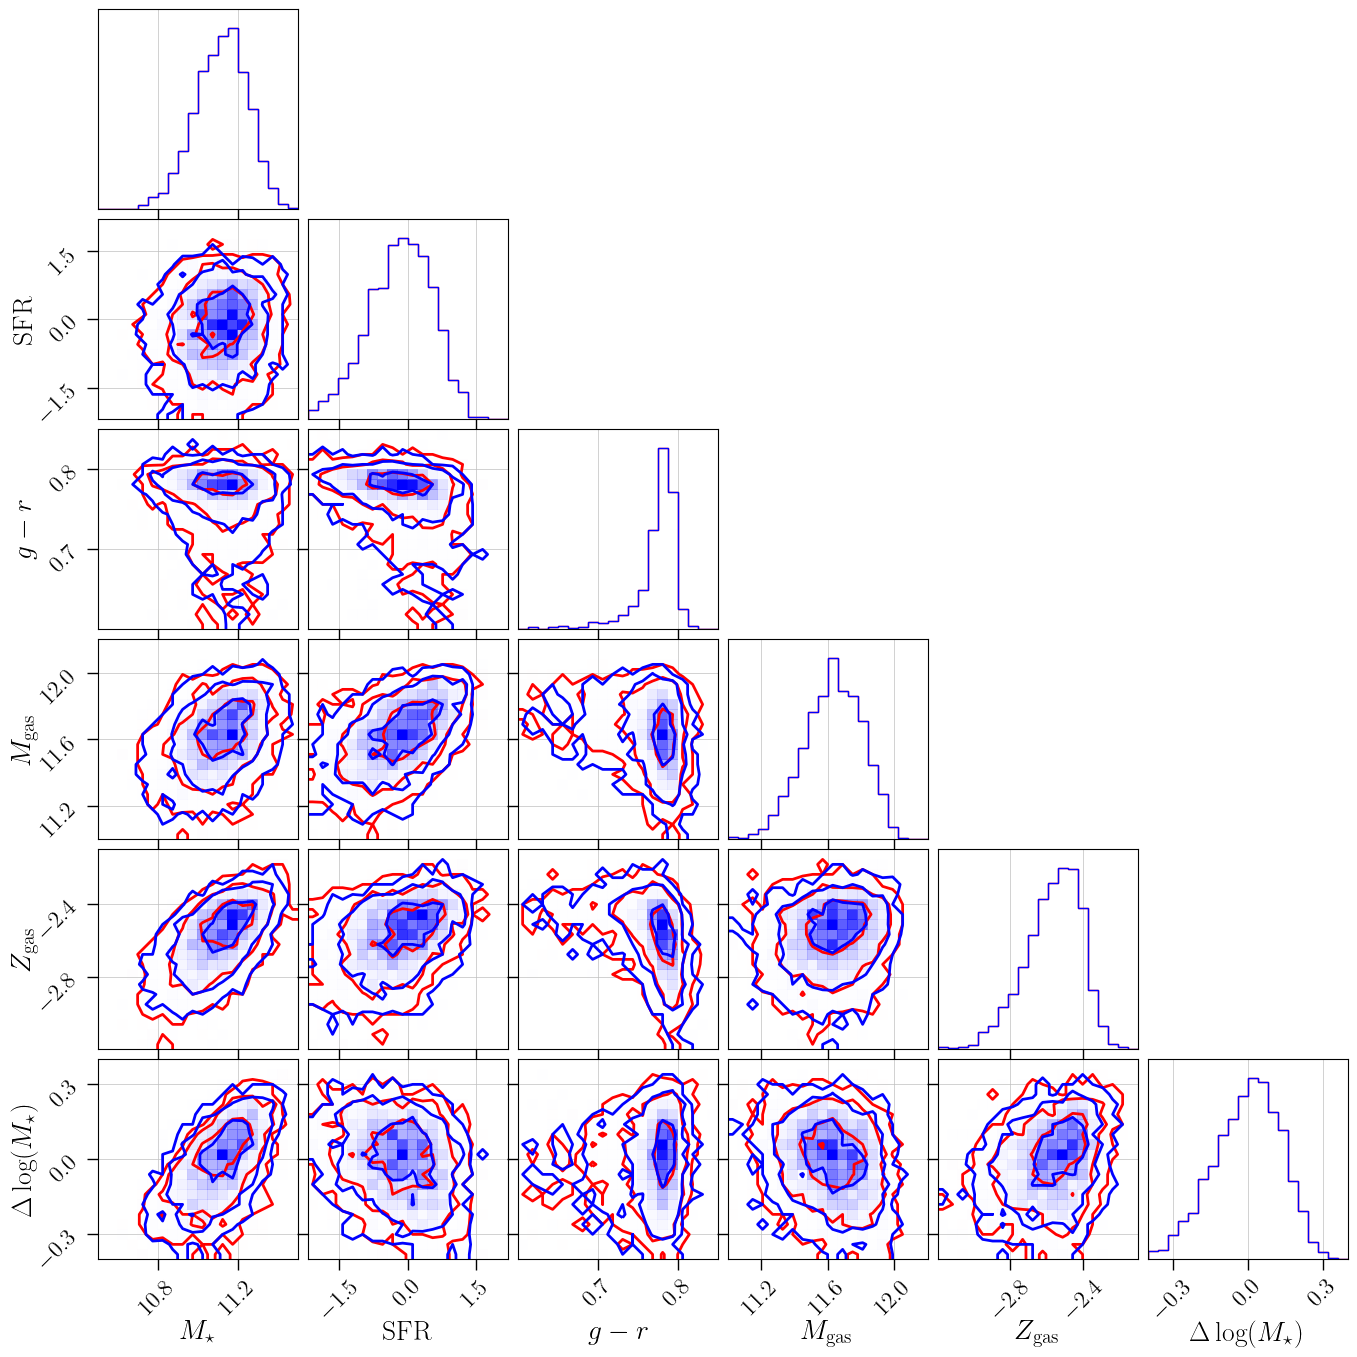

In [40]:
# try with corner 
import corner
levels = [1 - np.exp(-(x**2) / 2) for x in [1, 2, 3]]
latex_hydro_params = [LATEX_PARAMS_TNG[param] for param in hydro_params]
param_ranges = {'Mstar_vir': (10.5, 11.5), 'SFR_vir': (-2.2, 2.2), 'g-r': (0.6, 0.85), 'Mgas_vir': (11.0, 12.2), 
                'Zgas_vir': (-3.2, -2.1),  'msmhmr': (-0.4, 0.4), 
                # 'Zstar_vir': (-1.94, -1.61),
                }
ranges = [param_ranges[param] for param in hydro_params]


# ranges = [(0.65, 1.15), (0.94, 1.1), (-1, 2.5), (0.6, 0.85), (-0.56, 0.4), (10.6, 11.5)]
# do_log = [True, True, True, False, False, False]
# y_log = [np.log10(y[:, ii]) if do_log[ii] else y[:, ii] for ii in range(len(ranges))]
# y_log = np.array(y_log).T
# y_log1 = [np.log10(y1[:, ii]) if do_log[ii] else y1[:, ii] for ii in range(len(ranges))]
# y_log1 = np.array(y_log1).T
# y_log2 = [np.log10(y2[:, ii]) if do_log[ii] else y2[:, ii] for ii in range(len(ranges))]
# y_log2 = np.array(y_log2).T

fig = corner.corner(y, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', labels=latex_hydro_params, range=ranges)
fig = corner.corner(y1, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='b', labels=latex_hydro_params, fig=fig, range=ranges)
# fig = corner.corner(y_log1, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', range=ranges, fig=fig)
# fig = corner.corner(y_log2, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='g', range=ranges,fig=fig)

fig.savefig("../../results/tng/hydro_sampling_corner.png", bbox_inches='tight')


In [ ]:
# # try with corner 
# import corner
# levels = [1 - np.exp(-(x**2) / 2) for x in [1, 2, 3]]
# latex_hydro_params = [LATEX_PARAMS_TNG[param] for param in hydro_params]
# param_ranges = {'Mstar_vir': (10.5, 11.5), 'SFR_vir': (-2.2, 2.2), 'g-r': (0.6, 0.85), 'Mgas_vir': (11.0, 12.2), 'Zgas_vir': (-3.2, -2.1), 'Zstar_vir': (-1.94, -1.61), 'msmhmr': (-0.4, 0.4)}
# ranges = [param_ranges[param] for param in hydro_params]


# fig = corner.corner(y, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', labels=latex_hydro_params, range=ranges)
# fig = corner.corner(y2, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='b', labels=latex_hydro_params, fig=fig, range=ranges)


In [ ]:
# # try with corner 
# import corner
# levels = [1 - np.exp(-(x**2) / 2) for x in [1, 2, 3]]
# latex_hydro_params = [LATEX_PARAMS_TNG[param] for param in hydro_params]
# param_ranges = {'Mstar_vir': (10.5, 11.5), 'SFR_vir': (-2.2, 2.2), 'g-r': (0.6, 0.85), 'Mgas_vir': (11.0, 12.2), 'Zgas_vir': (-3.2, -2.1), 'Zstar_vir': (-1.94, -1.61), 'msmhmr': (-0.4, 0.4)}
# ranges = [param_ranges[param] for param in hydro_params]


# fig = corner.corner(y, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', labels=latex_hydro_params, range=ranges)
# fig = corner.corner(y3, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='b', labels=latex_hydro_params, fig=fig, range=ranges)


## Covariance matrix of DMO properties with galaxy properties

In [55]:
corrs = np.zeros((len(dmo_params), len(hydro_params)))

for ii in range(len(dmo_params)):
    for jj in range(len(hydro_params)):
        corrs[ii, jj] = spearmanr(dcat[dmo_params[ii]], cat[hydro_params[jj]])


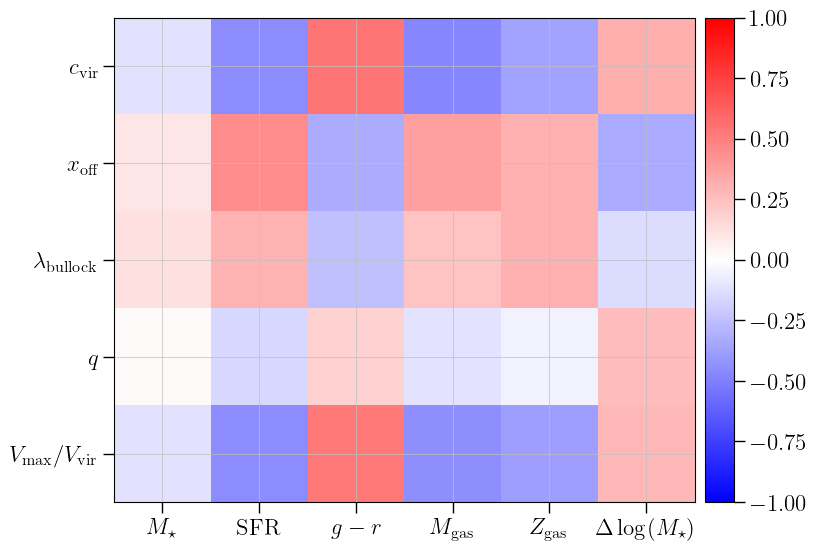

In [66]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(corrs, cmap='bwr', vmin=-1, vmax=1)

x_tick_labels = [LATEX_PARAMS_TNG[param] for param in hydro_params]
y_tick_labels = [LATEX_PARAMS_TNG[param] for param in dmo_params]

ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5], labels=x_tick_labels)
ax.set_yticks(ticks=[0, 1, 2, 3, 4], labels=y_tick_labels)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
fig.colorbar(im, cax=cax, orientation="vertical")


## Scaling relation best prediction

In [105]:
sfr_pred, gr_pred = model_dmo.predict(dm_peak)[:, len(dmo_params) + 1], model_dmo.predict(dm_peak)[:, len(dmo_params) + 2]
sfr_true, gr_true = cat['SFR_vir'].values, cat['g-r'].values

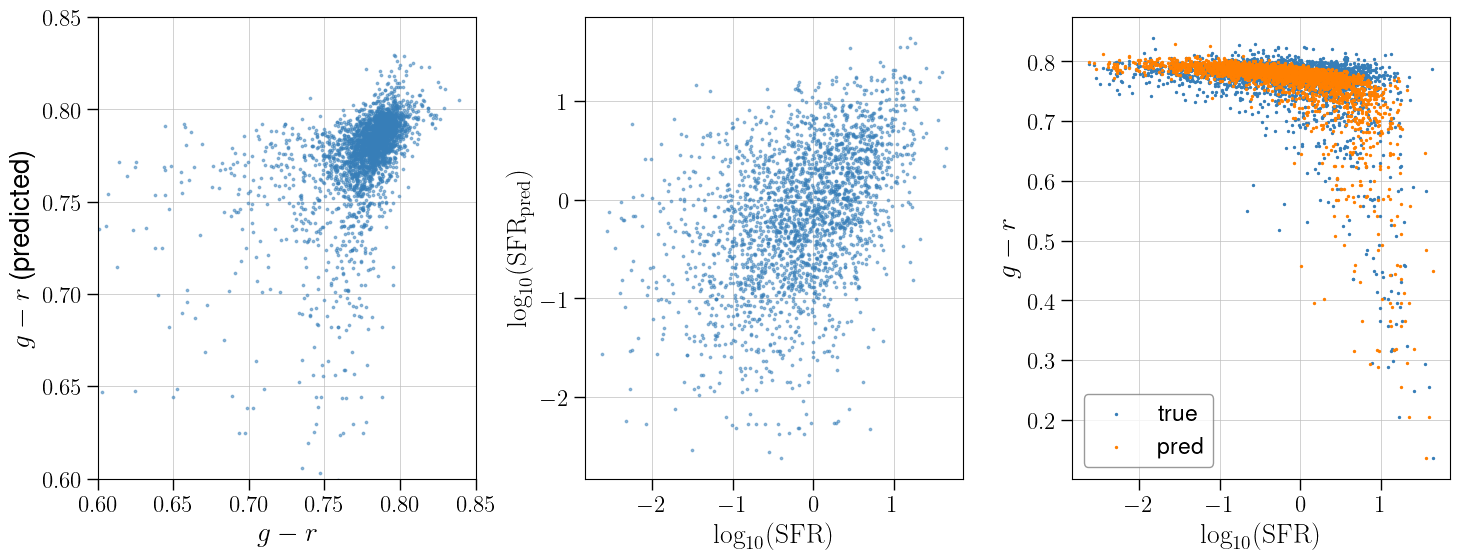

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

(ax1, ax2, ax3) = axes.flatten()

ax1.scatter(gr_true, gr_pred, s=3, alpha=0.5)
ax1.set_xlabel(r'$g-r$')
ax1.set_ylabel(r'$g-r$ (predicted)')
ax1.set_xlim(0.6, 0.85)
ax1.set_ylim(0.6, 0.85)


ax2.scatter(sfr_true, sfr_pred, s=3, alpha=0.5)
ax2.set_xlabel(r'$\log_{10}({\rm SFR})$')
ax2.set_ylabel(r'$\log_{10}({\rm SFR}_{\rm pred})$')


ax3.scatter(sfr_true, gr_true, s=2, label='true')
ax3.scatter(sfr_pred, gr_pred, s=2, label='pred')
ax3.legend()
ax3.set_xlabel(r'$\log_{10}({\rm SFR})$')
ax3.set_ylabel(r'$g-r$')

plt.tight_layout()

In [102]:
sfr_pred_2, gr_pred_2 = model_dmo_all.predict(x)[:,  1], model_dmo_all.predict(x)[:,  2]
sfr_true, gr_true = cat['SFR_vir'].values, cat['g-r'].values

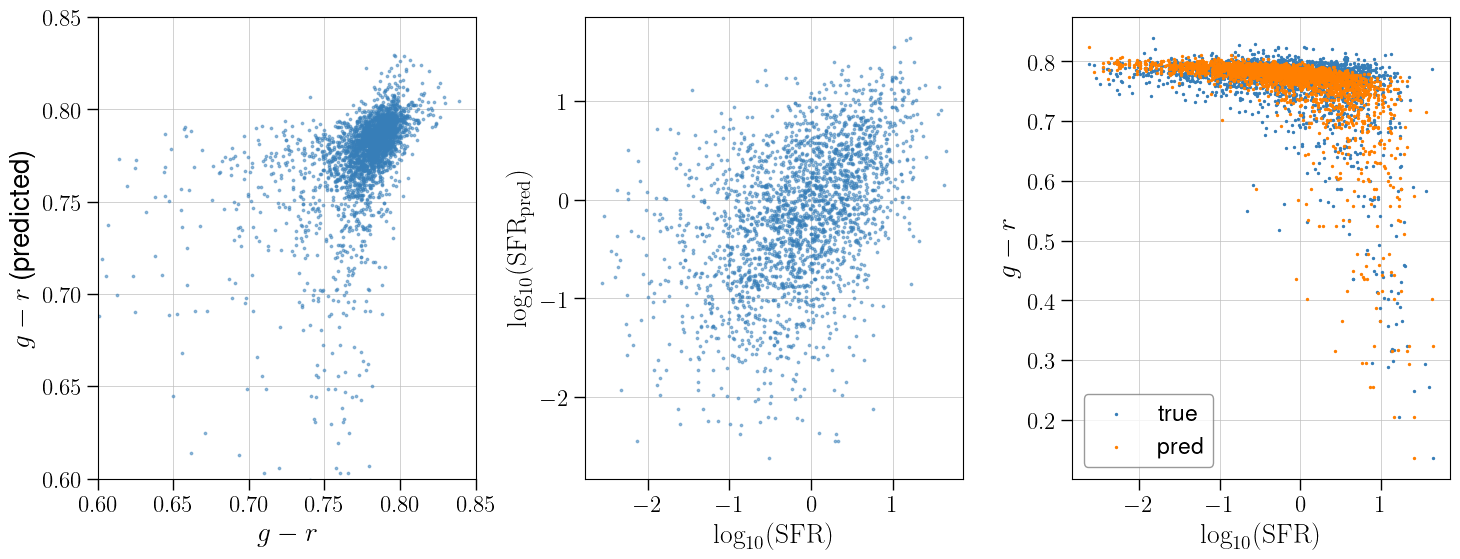

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

(ax1, ax2, ax3) = axes.flatten()

ax1.scatter(gr_true, gr_pred_2, s=3, alpha=0.5)
ax1.set_xlabel(r'$g-r$')
ax1.set_ylabel(r'$g-r$ (predicted)')
ax1.set_xlim(0.6, 0.85)
ax1.set_ylim(0.6, 0.85)


ax2.scatter(sfr_true, sfr_pred_2, s=3, alpha=0.5)
ax2.set_xlabel(r'$\log_{10}({\rm SFR})$')
ax2.set_ylabel(r'$\log_{10}({\rm SFR}_{\rm pred})$')


ax3.scatter(sfr_true, gr_true, s=2, label='true')
ax3.scatter(sfr_pred_2, gr_pred_2, s=2, label='pred')
ax3.legend()
ax3.set_xlabel(r'$\log_{10}({\rm SFR})$')
ax3.set_ylabel(r'$g-r$')

plt.tight_layout()

In [134]:
intercept

0.774804937369788

Text(0, 0.5, '$g-r$')

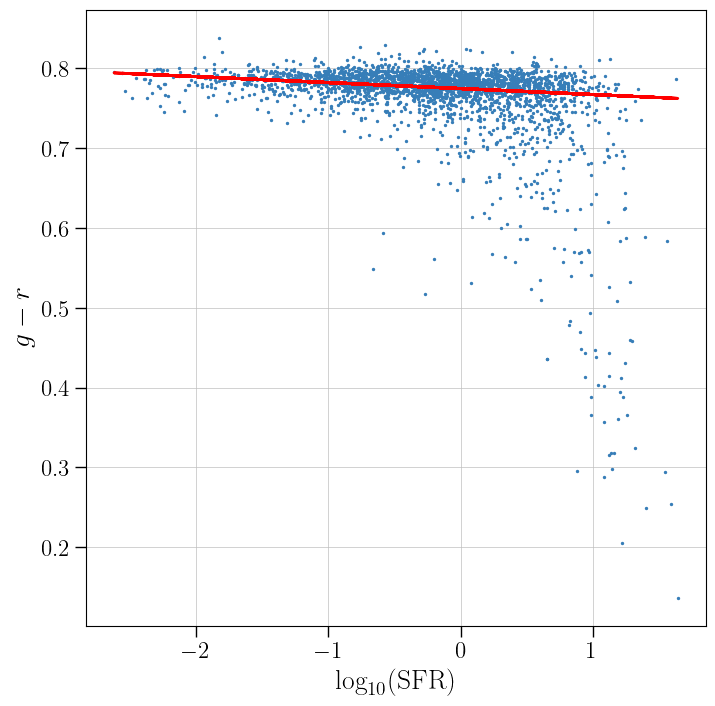

In [138]:
# fit line to sfr vs gr (true) but only for values of g-r above 0.7
# use this to predict sfr for gr_pred values that are outside this range
from scipy.stats import linregress

mask = (gr_true > 0.7) & ~np.isinf(sfr_true)
slope, intercept, r_value, p_value, std_err = linregress(sfr_true[mask], gr_true[mask])

# plot line to check it's good
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(sfr_true, gr_true,s=2)
ax.plot(sfr_true, slope * sfr_true + intercept, c='r')

plt.xlabel(r'$\log_{10}({\rm SFR})$')
plt.ylabel(r'$g-r$')

In [141]:
residual1

array([0.00946788, 0.00968742, 0.00359613, ..., 0.01352219,       -inf,
             -inf])

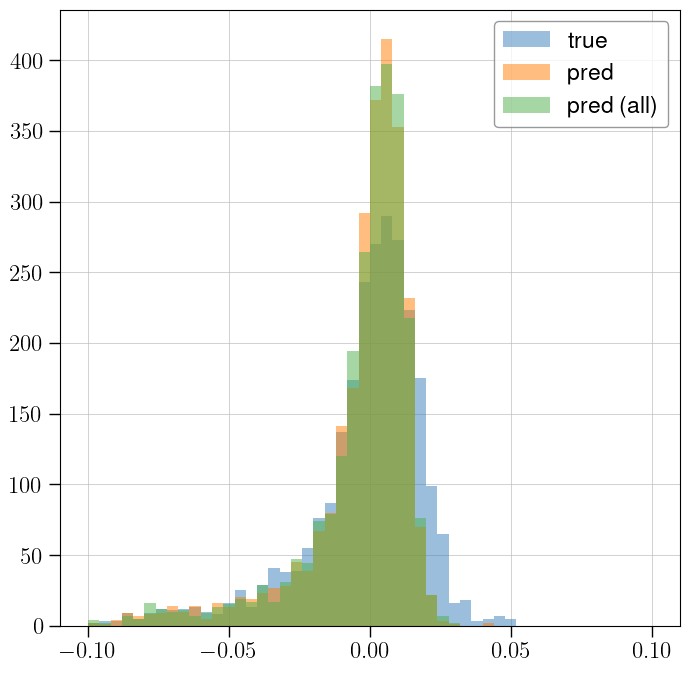

In [144]:
# color deviation from line histogram residual
residual1 = gr_true - (slope * sfr_true + intercept)
residual2 = gr_pred - (slope * sfr_pred + intercept)
residual3 = gr_pred_2 - (slope * sfr_pred_2 + intercept)

# all histograms in 1 plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
_, bins, _ = ax.hist(residual1, bins=50, label='true', alpha=0.5, range=(-.1,.1))
ax.hist(residual2, bins=bins, label='pred', alpha=0.5, range=(-0.1,0.1))
ax.hist(residual3, bins=bins, label='pred (all)', alpha=0.5, range=(-.1,.1))
ax.legend()



/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_11336/1059788168.py:3: RuntimeWarning: invalid value encountered in subtract
  _, bins, _ = plt.hist( sfr_pred - sfr_true, bins=50, alpha=0.5,range=(-3, 3), label='DMO MAH')
/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_11336/1059788168.py:4: RuntimeWarning: invalid value encountered in subtract
  plt.hist( sfr_pred_2 - sfr_true, bins=bins, alpha=0.5, label='DMO + DMO Properties')


Text(0.5, 0, '$\\log_{10}({\\rm SFR}_{\\rm pred}) - \\log_{10}({\\rm SFR})$')

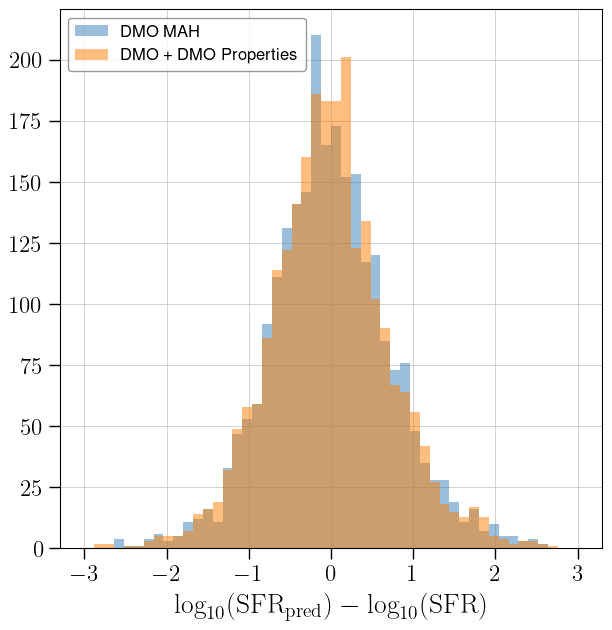

In [124]:
# residuals

_, bins, _ = plt.hist( sfr_pred - sfr_true, bins=50, alpha=0.5,range=(-3, 3), label='DMO MAH')
plt.hist( sfr_pred_2 - sfr_true, bins=bins, alpha=0.5, label='DMO + DMO Properties')
plt.legend(loc='upper left', prop={'size': 12})
plt.xlabel(r'$\log_{10}({\rm SFR}_{\rm pred}) - \log_{10}({\rm SFR})$')

Text(0.5, 0, '$(g-r)_{\\rm pred} - (g-r)$')

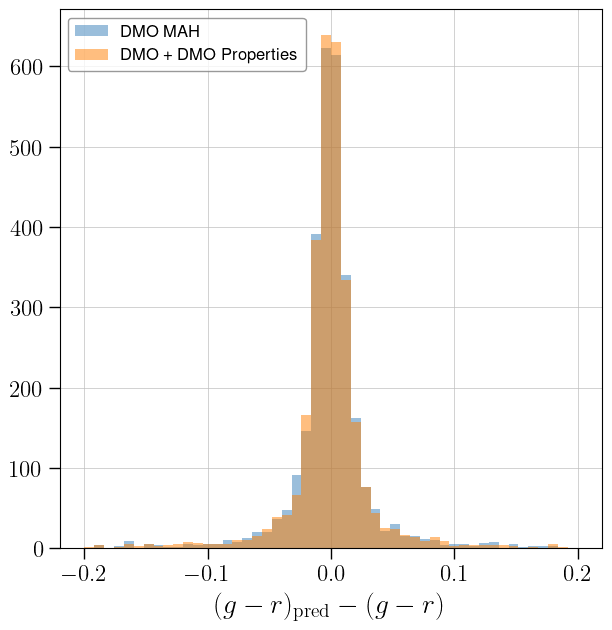

In [128]:
# residuals

_, bins, _ = plt.hist( gr_pred - gr_true, bins=50, alpha=0.5,range=(-.2, .2), label='DMO MAH')
plt.hist( gr_pred_2 - gr_true, bins=bins, alpha=0.5, label='DMO + DMO Properties')
plt.legend(loc='upper left', prop={'size': 12})
plt.xlabel(r'$(g-r)_{\rm pred} - (g-r)$')

## What drives peak at z = 2 for color

In [153]:
scales[60]

0.7936507936507936

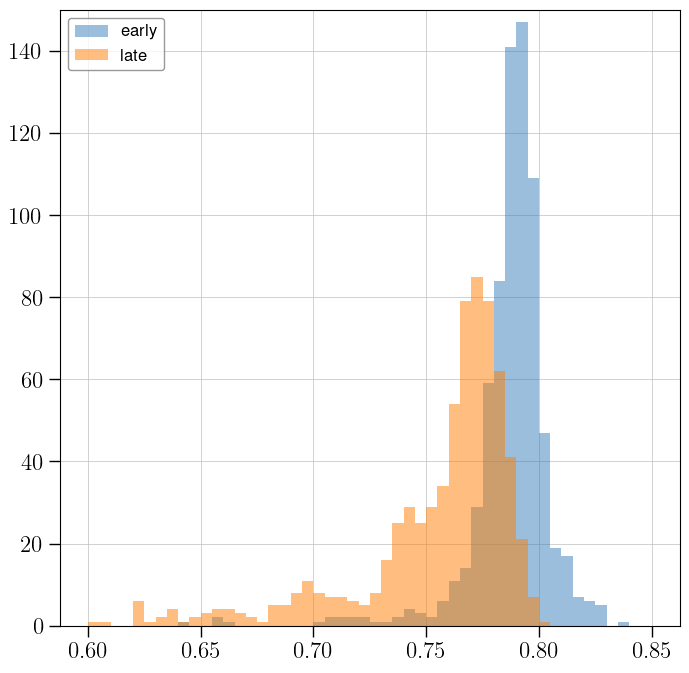

In [41]:
# split g-r by early-forming and late-forming
# define based on a = 0.3 with m(a) 
idx = 10
ma_z2 = dm_peak[:, idx]
gr = cat['g-r'].values

# lower quartile
late = np.quantile(ma_z2, 0.25) > ma_z2
early = np.quantile(ma_z2, 0.75) < ma_z2

# plot gr for early and late 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
_, bins, _ = ax.hist(gr[early], bins=50, alpha=0.5, label='early', range=(0.6, 0.85))
ax.hist(gr[late], bins=bins, alpha=0.5, label='late', range=(0.6, 0.85))
ax.set_ylim(0, 150)
ax.legend(loc='upper left', prop={'size': 12})

(0.0, 150.0)

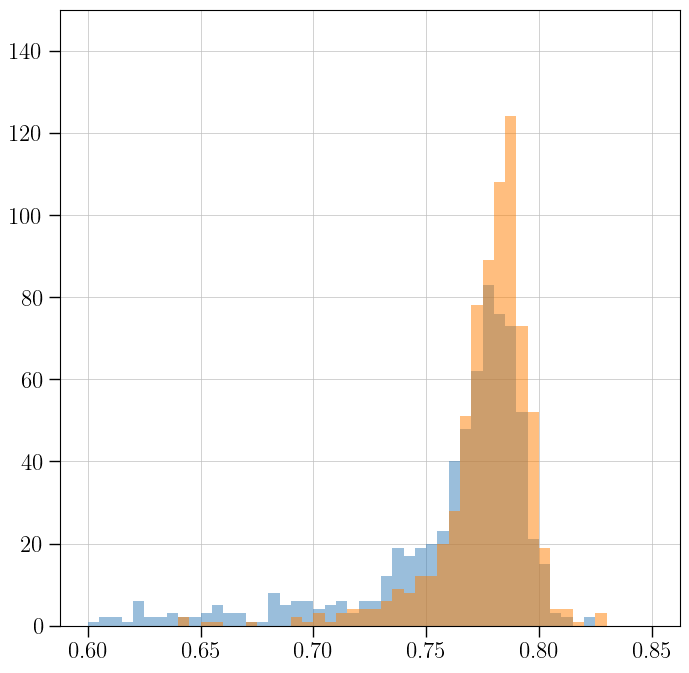

In [158]:
# split g-r by early-forming and late-forming
# define based on a = 0.3 with m(a) 
idx = 60
ma_z = dm_peak[:, idx]
gr = cat['g-r'].values

# lower quartile
late = np.quantile(ma_z, 0.25) > ma_z
early = np.quantile(ma_z, 0.75) < ma_z

# plot gr for early and late 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
_, bins, _ = ax.hist(gr[early], bins=50, alpha=0.5, label='early', range=(0.6, 0.85))
ax.hist(gr[late], bins=bins, alpha=0.5, label='late', range=(0.6, 0.85))
ax.set_ylim(0, 150)